In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import math
import statsmodels.api as sm
plt.rcParams['savefig.dpi'] = 600
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec

## Importing the data

In [104]:
# Final F3F4 selection coefficients, with outliers removed
s_F3F4 = pd.read_csv('Supp_data/s_300_5FC_no_out.csv') # Here, the FCY1_position of insertions have been adjusted

# Amino acid substitutions in the CDS: comparisons with the Després et al. (2022) screen
comps_CDS = pd.read_csv('Supp_data/CDS_byaa_comparisons.csv')

# Effects of single-nucleotide substitutions in FCY1
fcy1_muts_1nt = pd.read_csv("Supp_data/CDS_1nt_fromDesprés.csv")

## Preparing the data

### A) Median selection coefficients for F3F4 variants

In [107]:
# Selecting only the F3F4 data
s_F3F4 = s_F3F4[s_F3F4['In F3F4'] == True].copy().reset_index(drop=True)

# Shortening the 'Mutation type' labels
short_types = {'Substitution': 'Sub', 'Insertion': 'Ins', 'Deletion': 'Del'}
s_F3F4['Mutation type'] = s_F3F4['Mutation type'].apply(lambda x: short_types[x])

# Making a version without duplicates (only median values)
s_F3F4_med = s_F3F4[['Genotype', 'Position', 'Mutation type', 'FCY1_position',
                    'Median_s_ignored', 'Min_s_ignored', 'Max_s_ignored']].copy().drop_duplicates()

# Computing medians and minmax by position
s_F3F4_bypos = s_F3F4_med[['FCY1_position', 'Mutation type', 'Median_s_ignored']].copy().groupby(by=['FCY1_position', 'Mutation type'], as_index=False).median()
s_min_bypos = s_F3F4_med[['FCY1_position', 'Mutation type', 'Min_s_ignored']].copy().groupby(by=['FCY1_position', 'Mutation type'], as_index=False).min()
s_max_bypos = s_F3F4_med[['FCY1_position', 'Mutation type', 'Max_s_ignored']].copy().groupby(by=['FCY1_position', 'Mutation type'], as_index=False).max()

s_F3F4_bypos = pd.merge(s_F3F4_bypos, s_min_bypos, on=['FCY1_position', 'Mutation type'], how='outer')
s_F3F4_bypos = pd.merge(s_F3F4_bypos, s_max_bypos, on=['FCY1_position', 'Mutation type'], how='outer')

In [108]:
s_F3F4_med[(s_F3F4_med['Median_s_ignored'] > 0) & (s_F3F4_med['Min_s_ignored'] > 0)].sort_values(by='Median_s_ignored', ascending=False)

,Genotype,Position,Mutation type,FCY1_position,Median_s_ignored,Min_s_ignored,Max_s_ignored
858,I-134_1nt_-toT,134,Ins,-70,0.034311,0.017263,0.051373
117,I-195_1nt_-toG,195,Ins,-9,0.033401,0.005113,0.039036
11,I-85_1nt_-toC,85,Ins,-119,0.029953,0.006138,0.053767
7964,S-143_1nt_AtoG,143,Sub,-62,0.029946,0.001279,0.118685
843,S-196_1nt_TtoG,196,Sub,-9,0.027871,0.016984,0.051648
254,D-61_1nt_Ato-,61,Del,-144,0.027710,0.018515,0.032863
385,S-201_1nt_AtoG,201,Sub,-4,0.027155,0.007464,0.082583
914,S-138_1nt_AtoC,138,Sub,-67,0.025522,0.014005,0.057108
132,I-118_1nt_-toT,118,Ins,-86,0.023716,0.007791,0.033512
91,I-77_1nt_-toC,77,Ins,-127,0.023031,0.007013,0.060790


In [109]:
s_F3F4_med[(s_F3F4_med['Median_s_ignored'] < 0) & (s_F3F4_med['Max_s_ignored'] < 0)].sort_values(by='Median_s_ignored', ascending=True)

,Genotype,Position,Mutation type,FCY1_position,Median_s_ignored,Min_s_ignored,Max_s_ignored
1102,I-68_1nt_-toC,68,Ins,-136,-0.058931,-0.071030,-0.046831
106,I-167_1nt_-toC,167,Ins,-37,-0.050690,-0.072823,-0.020999
754,I-101_1nt_-toC,101,Ins,-103,-0.038683,-0.059558,-0.011212
7960,S-139_1nt_TtoA,139,Sub,-66,-0.036124,-0.037115,-0.035132
71,I-188_1nt_-toG,188,Ins,-16,-0.033174,-0.048534,-0.015247
...,...,...,...,...,...,...,...
576,I-59_1nt_-toC,59,Ins,-145,-0.004650,-0.015446,-0.000875
531,I-187_1nt_-toT,187,Ins,-17,-0.003154,-0.014769,-0.001620
339,I-144_1nt_-toC,144,Ins,-60,-0.002708,-0.010004,-0.000137
329,I-72_1nt_-toA,72,Ins,-132,-0.002404,-0.014338,-0.000488


Looking at the resolution of the assay

In [111]:
rep_width = s_F3F4_med['Max_s_ignored'] - s_F3F4_med['Min_s_ignored']

In [112]:
res_est = np.mean(rep_width)
print(res_est)

0.044492049173999265


In [113]:
# Estimated effects which are greater than this resolution
hits_pos = s_F3F4_med[s_F3F4_med['Median_s_ignored'] > res_est/2]
hits_neg = s_F3F4_med[s_F3F4_med['Median_s_ignored'] < -(res_est/2)]

In [114]:
hits_pos.sort_values(by='Median_s_ignored', ascending=False)

,Genotype,Position,Mutation type,FCY1_position,Median_s_ignored,Min_s_ignored,Max_s_ignored
811,I-96_1nt_-toC,96,Ins,-108,0.056012,-0.075823,0.061407
849,S-137_1nt_AtoG,137,Sub,-68,0.053024,-0.008331,0.119502
141,D-119_1nt_Gto-,119,Del,-86,0.044058,-0.013235,0.055714
53,I-199_1nt_-toC,199,Ins,-5,0.035796,-0.130440,0.045104
858,I-134_1nt_-toT,134,Ins,-70,0.034311,0.017263,0.051373
117,I-195_1nt_-toG,195,Ins,-9,0.033401,0.005113,0.039036
11,I-85_1nt_-toC,85,Ins,-119,0.029953,0.006138,0.053767
7964,S-143_1nt_AtoG,143,Sub,-62,0.029946,0.001279,0.118685
311,S-146_1nt_TtoG,146,Sub,-59,0.029377,-0.005990,0.045249
83,S-117_1nt_AtoC,117,Sub,-88,0.029022,-0.057155,0.033405


In [115]:
hits_neg.sort_values(by='Median_s_ignored')

,Genotype,Position,Mutation type,FCY1_position,Median_s_ignored,Min_s_ignored,Max_s_ignored
1102,I-68_1nt_-toC,68,Ins,-136,-0.058931,-0.071030,-0.046831
108,I-120_1nt_-toC,120,Ins,-84,-0.051862,-0.111211,0.006312
106,I-167_1nt_-toC,167,Ins,-37,-0.050690,-0.072823,-0.020999
993,I-138_1nt_-toC,138,Ins,-66,-0.048134,-0.055692,0.016577
94,I-57_1nt_-toC,57,Ins,-147,-0.047601,-0.097966,0.029996
4,I-149_1nt_-toG,149,Ins,-55,-0.040280,-0.064148,0.012103
754,I-101_1nt_-toC,101,Ins,-103,-0.038683,-0.059558,-0.011212
121,I-189_1nt_-toC,189,Ins,-15,-0.038452,-0.097736,0.007370
7960,S-139_1nt_TtoA,139,Sub,-66,-0.036124,-0.037115,-0.035132
140,D-158_1nt_Tto-,158,Del,-47,-0.034256,-0.055170,0.025528


### B) Correlations between selection coefficients for CDS spike-ins (by aa)

Computing a loess regression, with a 95% confidence interval

Using the code in: https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html

In [119]:
def lowess_with_confidence_bounds(x, y, eval_x, N=200, conf_interval=0.95, lowess_kw=None):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw)

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top

In [120]:
# Compute the 95% confidence interval
eval_x = np.linspace(np.min(comps_CDS['Median_s_T0toT2']), np.max(comps_CDS['Median_s_T0toT2']), 50)
smoothed_comp, bottom_comp, top_comp = lowess_with_confidence_bounds(comps_CDS['Median_s_T0toT2'], comps_CDS['FC_score'], eval_x, lowess_kw={"frac": 0.275})

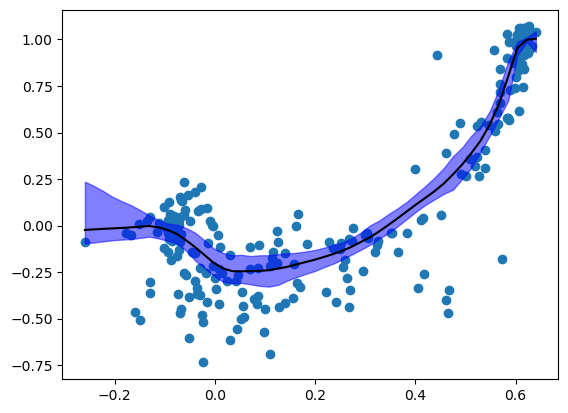

In [121]:
plt.scatter(comps_CDS['Median_s_T0toT2'], comps_CDS['FC_score'])
plt.plot(eval_x, smoothed_comp, c="k")
plt.fill_between(eval_x, bottom_comp, top_comp, alpha=0.5, color="b")

This looks good enough!

### C- Effects of single-nucleotide substitutions in FCY1 (from Després et al.)

In [124]:
abbv_dict = {'Resistant': 'R', 'Susceptible':'S'}
fcy1_muts_1nt['Mut_label'] = fcy1_muts_1nt['Mut_label'].apply(lambda x: abbv_dict[x])

### C-D) Agreement between the "resistant" and "susceptible" classifications

In [126]:
abbv_dict = {'Resistant': 'R', 'Susceptible':'S'}
comps_CDS['Label_SA'] = comps_CDS['Label_SA'].apply(lambda x: abbv_dict[x])
comps_CDS['Label_PD'] = comps_CDS['Label_PD'].apply(lambda x: abbv_dict[x])

In [127]:
# Computing the "confusion matrix"
comps_CDS['Occurrences'] = 1
comps_CDS = comps_CDS.rename(columns={'Label_SA': 'Current study', 'Label_PD': 'Després et al.(2022)'})
class_mat = comps_CDS[['Current study', 'Després et al.(2022)', 'Occurrences']].groupby(by=['Current study', 'Després et al.(2022)'], as_index=False).sum().pivot(columns='Després et al.(2022)', index='Current study', values='Occurrences')

In [128]:
class_mat = class_mat.fillna(0)
class_mat = class_mat.astype('int32')

In [129]:
class_mat

Després et al.(2022),R,S
Current study,,
R,148,29
S,0,134


<Axes: xlabel='Current study', ylabel='Després et al.(2022)'>

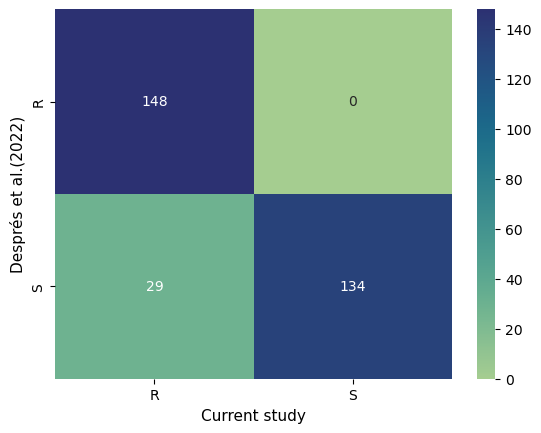

In [130]:
sns.heatmap(class_mat.transpose(), annot=True, fmt='.0f', cmap='crest')

## Assembling the figure

In [132]:
mut_palette = {'Sub': cm.tab10.colors[9], 
               'Ins': cm.tab20b.colors[1],
               'Del': cm.tab10.colors[3]}
axes_annot = (-50, 185)

#class_palette = {'S': cm.tab10.colors[0],
                #'R': cm.tab10.colors[1]}

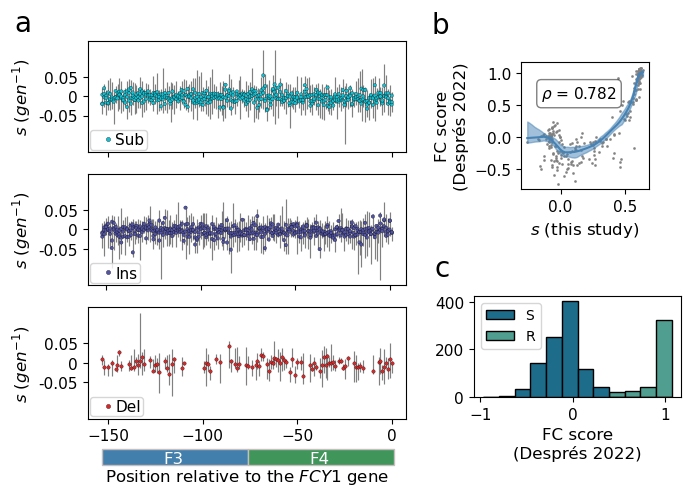

In [194]:
fig = plt.figure(constrained_layout=False, figsize=(6.48, 3.78))

# First column, for the three plots of Fig A
gs1 = fig.add_gridspec(nrows=20, ncols=8, left=0.00, right=0.66, bottom=0.00, top=1.00 )
# Second column, for B and C
gs2 = fig.add_gridspec(nrows=175, ncols=102, left=0.66, right=1.00, bottom=0.00, top=1.00)

# Adding the axes
ax1 = fig.add_subplot(gs1[0:6, 1:7])
ax2 = fig.add_subplot(gs1[7:13, 1:7], sharey=ax1)
ax3 = fig.add_subplot(gs1[14:20, 1:7], sharey=ax1)

ax4 = fig.add_subplot(gs2[10:69, 28:87])
ax5 = fig.add_subplot(gs2[118:165, 6:102])

# Filling panel A: selection coefficients
axes_list = [ax1, ax2, ax3]
types_list = ['Sub', 'Ins', 'Del']

for plot_num in [0, 1, 2]:
    type_to_plot = types_list[plot_num]
    points_subset = s_F3F4_med[s_F3F4_med['Mutation type'] == type_to_plot].copy().reset_index(drop=True).infer_objects()
    bars_subset = s_F3F4_bypos[s_F3F4_bypos['Mutation type'] == type_to_plot].copy().reset_index(drop=True).infer_objects()
    sub_err = np.array([bars_subset['Median_s_ignored'] - bars_subset['Min_s_ignored'],
                        bars_subset['Max_s_ignored'] - bars_subset['Median_s_ignored']])

    plot_s = sns.stripplot(data=points_subset, x='FCY1_position', y='Median_s_ignored', hue='Mutation type', 
                           ax=axes_list[plot_num], palette=mut_palette, s=2.5, edgecolor='black', linewidth=0.20, native_scale=True)
    h_s, l_s = plot_s.get_legend_handles_labels()
    plot_s.legend(h_s, l_s, handletextpad=-0.5, title=None, loc="lower left",
                   borderaxespad=0.15, borderpad=0.15, fontsize=11, markerscale=1.25)
    axes_list[plot_num].tick_params(axis='both', labelsize=11)
    axes_list[plot_num].errorbar(bars_subset['FCY1_position'], bars_subset['Median_s_ignored'], yerr=sub_err,
                                 fmt='none', zorder=0, ecolor='grey', linewidth=0.85)

    # y axis label
    axes_list[plot_num].set_ylabel(r"$s$ ($gen^{-1}$)", fontsize=12)
    axes_list[plot_num].set_yticks([-0.05, 0, 0.05], labels=[-0.05, 0, 0.05])

# Filling panel B: comparison with lowess regression
ax4.scatter(comps_CDS['Median_s_T0toT2'], comps_CDS['FC_score'], c='grey', s=1, zorder=0, alpha=0.85)
ax4.plot(eval_x, smoothed_comp, c="steelblue", zorder=2)
ax4.fill_between(eval_x, bottom_comp, top_comp, alpha=0.5, color="steelblue", zorder=1)
ax4.tick_params(axis='both', labelsize=11)
# Computing and adding spearman correlation
calc_subset = comps_CDS.dropna(subset=['Median_s_T0toT2', 'FC_score']).reset_index(drop=True)
spearman_coeff = stats.spearmanr(calc_subset['Median_s_T0toT2'], calc_subset['FC_score'])
ax4.annotate(r"$\rho$ = "f'{round(spearman_coeff[0], 3)}',
             (-0.15, 0.6), bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=11)


# Filling panel C: Effect of single-nucleotide substitutions in the FCY1 CDS
sns.histplot(data=fcy1_muts_1nt, x='FC_score', hue='Mut_label', palette='crest_r', ax=ax5, legend=True, alpha=1)
ax5.get_legend().set(title=None, loc='upper left')
ax5.tick_params(axis='both', labelsize=11)

# Adjusting axes labels
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax2.set_xticklabels([])
ax2.set_xlabel('')
ax3.set_xlabel(r"Position relative to the $\it{FCY1}$ gene", fontsize=12, labelpad=17)

ax4.set_xlabel(r"$s$ (this study)", fontsize=12)
ax4.set_ylabel('FC score\n(Després 2022)', fontsize=12)

ax5.set_ylabel('')
ax5.set_xlabel('FC score\n(Després 2022)', fontsize=12)

# Adding rectangles to identify regions
ax3.add_patch(Rectangle((-153, -0.2225), 77, -0.04, facecolor='#427fac', edgecolor='#c8bdbd', clip_on=False))  # F3
ax3.annotate("F3", (-115.5, -0.2465), annotation_clip=False, color='white', ha='center', va='center', fontsize=12, zorder=1)
ax3.add_patch(Rectangle((-76, -0.2225), 77, -0.04, facecolor='#3f955a', edgecolor='#c8bdbd', clip_on=False))  # F4
ax3.annotate("F4", (-38.5, -0.2465), annotation_clip=False, color='white', ha='center', va='center', fontsize=12, zorder=1)

# Identifying the plots
ax1.annotate('a', (-53, 87), xycoords='axes points', annotation_clip=False, fontsize=20)
ax4.annotate('b', (-65, 112.5), xycoords='axes points', annotation_clip=False, fontsize=20)
ax5.annotate('c', (-28.5, 87.5), xycoords='axes points', annotation_clip=False, fontsize=20)

fig4 = plt.gcf()
fig4.savefig(f"Final_figs/Fig4.tiff", bbox_inches='tight')

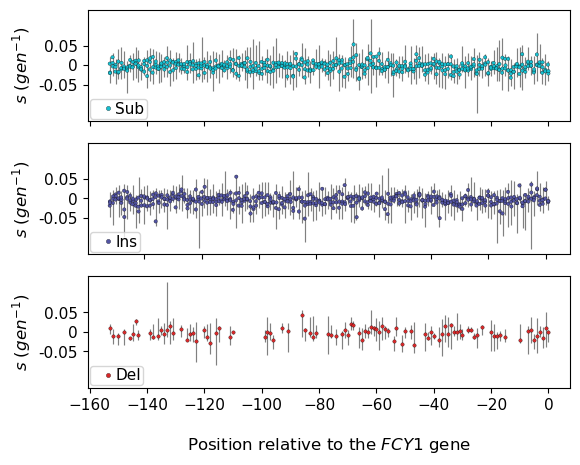

In [134]:
# Version for talk
fig = plt.figure(constrained_layout=False, figsize=(6.48, 3.78))

# First column, for the three plots of Fig A
gs1 = fig.add_gridspec(nrows=20, ncols=8, left=0.00, right=1.0, bottom=0.00, top=1.00 )

# Adding the axes
ax1 = fig.add_subplot(gs1[0:6, 1:7])
ax2 = fig.add_subplot(gs1[7:13, 1:7], sharey=ax1)
ax3 = fig.add_subplot(gs1[14:20, 1:7], sharey=ax1)

# Filling panel A: selection coefficients
axes_list = [ax1, ax2, ax3]
types_list = ['Sub', 'Ins', 'Del']

for plot_num in [0, 1, 2]:
    type_to_plot = types_list[plot_num]
    points_subset = s_F3F4_med[s_F3F4_med['Mutation type'] == type_to_plot].copy().reset_index(drop=True).infer_objects()
    bars_subset = s_F3F4_bypos[s_F3F4_bypos['Mutation type'] == type_to_plot].copy().reset_index(drop=True).infer_objects()
    sub_err = np.array([bars_subset['Median_s_ignored'] - bars_subset['Min_s_ignored'],
                        bars_subset['Max_s_ignored'] - bars_subset['Median_s_ignored']])

    plot_s = sns.stripplot(data=points_subset, x='FCY1_position', y='Median_s_ignored', hue='Mutation type', 
                           ax=axes_list[plot_num], palette=mut_palette, s=2.5, edgecolor='black', linewidth=0.20, native_scale=True)
    h_s, l_s = plot_s.get_legend_handles_labels()
    plot_s.legend(h_s, l_s, handletextpad=-0.5, title=None, loc="lower left",
                   borderaxespad=0.15, borderpad=0.15, fontsize=11, markerscale=1.25)
    axes_list[plot_num].tick_params(axis='both', labelsize=11)
    axes_list[plot_num].errorbar(bars_subset['FCY1_position'], bars_subset['Median_s_ignored'], yerr=sub_err,
                                 fmt='none', zorder=0, ecolor='grey', linewidth=0.85)

    # y axis label
    axes_list[plot_num].set_ylabel(r"$s$ ($gen^{-1}$)", fontsize=12)
    axes_list[plot_num].set_yticks([-0.05, 0, 0.05], labels=[-0.05, 0, 0.05])

# Adjusting axes labels
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax2.set_xticklabels([])
ax2.set_xlabel('')
ax3.set_xlabel(r"Position relative to the $\it{FCY1}$ gene", fontsize=12, labelpad=17)

fig4_talk = plt.gcf()
fig4_talk.savefig(f"Final_figs/Fig4_talk.tiff", bbox_inches='tight')

In [135]:
print(f'p-val = {spearman_coeff[1]:.3e}')

p-val = 2.589e-65


In [136]:
np.min(s_F3F4_med['Median_s_ignored'])

-0.0589305155303897

In [137]:
np.max(s_F3F4_med['Median_s_ignored'])

0.0560117068485898

In [138]:
grand_med_s = np.median(s_F3F4_med['Median_s_ignored'])
print(grand_med_s)

-0.00316533342330625


In [139]:
# Number of genotypes of each type
n_subs = s_F3F4_med[s_F3F4_med['Mutation type'] == 'Sub'].shape[0]
n_ins = s_F3F4_med[s_F3F4_med['Mutation type'] == 'Ins'].shape[0]
n_del = s_F3F4_med[s_F3F4_med['Mutation type'] == 'Del'].shape[0]

print(f"n_sub = {n_subs}")
print(f"n_ins = {n_ins}")
print(f"n_del = {n_del}")

n_sub = 462
n_ins = 462
n_del = 96


In [140]:
rep_width = s_F3F4_med['Max_s_ignored'] - s_F3F4_med['Min_s_ignored']

In [141]:
np.min(rep_width)

0.001983099957730605

In [142]:
np.max(rep_width)

0.1755441680632997

In [143]:
np.mean(rep_width)

0.044492049173999265

In [144]:
comps_CDS

,Num_codon,WT_codon,WT_aa,Mut_aa,Median_s_T0toT2,Min_med_s,Max_med_s,Variant_type,FC_score,Current study,Després et al.(2022),Percentile_SA,Percentile_PD,Occurrences
0,65,ATC,I,*,0.625398,0.618454,0.632343,Nonsense,0.986618,R,R,0.971061,0.739550,1
1,65,ATC,I,A,0.624161,0.594500,0.630521,Missense,0.928501,R,R,0.961415,0.633441,1
2,65,ATC,I,C,0.617546,0.617353,0.617739,Missense,0.842884,R,R,0.871383,0.601286,1
3,65,ATC,I,D,0.615864,0.601317,0.630411,Missense,0.993405,R,R,0.836013,0.774920,1
4,65,ATC,I,E,0.627980,0.624930,0.631029,Missense,0.961594,R,R,0.990354,0.668810,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,101,TAC,Y,S,0.546353,0.533163,0.586696,Missense,0.542323,R,R,0.543408,0.540193,1
307,101,TAC,Y,T,0.043104,-0.308583,0.061251,Missense,-0.556617,S,S,0.286174,0.019293,1
308,101,TAC,Y,V,0.383074,0.357603,0.502849,Missense,-0.039937,R,S,0.466238,0.340836,1
309,101,TAC,Y,W,0.236272,0.236272,0.236272,Missense,-0.120034,S,S,0.395498,0.257235,1


## S12 Fig

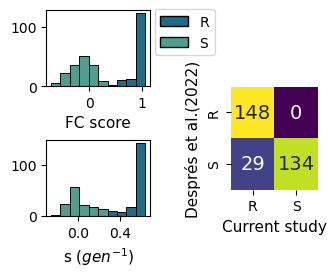

In [146]:
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 10

fig = plt.figure(constrained_layout=False, figsize=(8, 4.2))

gs1 = fig.add_gridspec(nrows=116, ncols=102, left=0.0, right=1.00, bottom=0.00, top=1.00)

# Adding the axes
ax5 = fig.add_subplot(gs2[30:62, 0:39])
ax6 = fig.add_subplot(gs2[84:116, 0:39])

ax7= fig.add_subplot(gs2[62:105, 69:102])


sns.histplot(data=comps_CDS, x='FC_score', hue='Després et al.(2022)', ax=ax5, legend=True, palette='crest_r', alpha=1)
ax5.get_legend().set(title=None, loc='upper left', zorder=0, bbox_to_anchor=(0.98, 1.10))
ax5.set_ylabel('')
sns.histplot(data=comps_CDS, x='Median_s_T0toT2', hue='Current study', ax=ax6, legend=False, palette='crest_r', alpha=1)
ax6.set_ylabel('')
ax6.set_xticks([0, 0.4], labels=[0.0, 0.4])

ax5.set_xlabel('FC score')
ax6.set_xlabel('s'r" ($gen^{-1}$)")

class_map = sns.heatmap(class_mat.transpose(), annot=True, fmt='.0f', cmap='viridis', ax=ax7, annot_kws={'fontsize':14}, cbar=False)


FigS12 = plt.gcf()
FigS12.savefig('Supp_figs/S12Fig.tiff', bbox_inches='tight')

In [197]:
comps_CDS

,Num_codon,WT_codon,WT_aa,Mut_aa,Median_s_T0toT2,Min_med_s,Max_med_s,Variant_type,FC_score,Current study,Després et al.(2022),Percentile_SA,Percentile_PD,Occurrences
0,65,ATC,I,*,0.625398,0.618454,0.632343,Nonsense,0.986618,R,R,0.971061,0.739550,1
1,65,ATC,I,A,0.624161,0.594500,0.630521,Missense,0.928501,R,R,0.961415,0.633441,1
2,65,ATC,I,C,0.617546,0.617353,0.617739,Missense,0.842884,R,R,0.871383,0.601286,1
3,65,ATC,I,D,0.615864,0.601317,0.630411,Missense,0.993405,R,R,0.836013,0.774920,1
4,65,ATC,I,E,0.627980,0.624930,0.631029,Missense,0.961594,R,R,0.990354,0.668810,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,101,TAC,Y,S,0.546353,0.533163,0.586696,Missense,0.542323,R,R,0.543408,0.540193,1
307,101,TAC,Y,T,0.043104,-0.308583,0.061251,Missense,-0.556617,S,S,0.286174,0.019293,1
308,101,TAC,Y,V,0.383074,0.357603,0.502849,Missense,-0.039937,R,S,0.466238,0.340836,1
309,101,TAC,Y,W,0.236272,0.236272,0.236272,Missense,-0.120034,S,S,0.395498,0.257235,1


## Exporting data used as Supp Table 8

In [148]:
# For the first sheet (T8_A), the file median_s_F3F4.csv from
# Aggregate_s_coeffs.ipynb is used

T8_B = s_F3F4[['Genotype',  'Mutation type', 'Position', 'FCY1_position',
               'New_nt', 'In F3F4', 'Alias', 'Bio_rep', 'Tech_rep',
               'To_ignore', 'N_T0', 'N_T3', 's_T0toT1_Ref', 's_T0toT2_Ref',
               's_T0toT3_Ref', 'MAD_s_T0toT2', 'n_MAD']].copy()
T8_B.to_csv("Supp_data/SuppTable8_partB.csv")

In [149]:
meds_s_test = pd.read_csv("Supp_data/median_s_F3F4.csv")

In [150]:
meds_s_test.sort_values(by='FCY1_position', ascending=False)

,Genotype,Position,In F3F4,Mutation type,Median_s_T0toT2,Median_s_ignored,Min_s_ignored,Max_s_ignored,FCY1_position,New_nt,not_zero_p-val,n_observed,not_zero_FDR
317,I-205_1nt_-toC,205,True,Insertion,-0.006470,-0.009231,-0.030378,-0.005866,1,C,0.095630,4.0,0.902337
452,I-205_1nt_-toT,205,True,Insertion,-0.010652,-0.007162,-0.011156,-0.003791,1,T,0.032504,4.0,0.902337
74,I-205_1nt_-toG,205,True,Insertion,0.003268,-0.006847,-0.030119,0.007598,1,G,0.347797,4.0,0.915612
325,S-205_1nt_AtoG,205,True,Substitution,-0.025038,-0.021630,-0.039825,0.010551,0,G,0.184006,4.0,0.902337
592,S-205_1nt_AtoT,205,True,Substitution,-0.017800,-0.015705,-0.038574,0.007276,0,T,0.276046,4.0,0.915612
...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,S-53_1nt_TtoC,53,True,Substitution,-0.020754,-0.003453,-0.023811,0.003554,-152,C,0.355526,4.0,0.915612
40,S-52_1nt_AtoC,52,True,Substitution,-0.019364,-0.019364,-0.032815,0.001802,-153,C,0.124211,4.0,0.902337
242,S-52_1nt_AtoT,52,True,Substitution,-0.007046,-0.020680,-0.047238,-0.010888,-153,T,0.050232,4.0,0.902337
131,S-52_1nt_AtoG,52,True,Substitution,0.003593,0.003593,-0.015714,0.019976,-153,G,0.721113,4.0,0.977947
